In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

In [40]:
# %matplotlib widget
# plt.rcParams["figure.autolayout"] = True
# plt.rcParams["figure.figsize"] = [7,5]

ModuleNotFoundError: No module named 'ipympl'

In [2]:
device = 'cpu'

In [3]:
from copy import deepcopy

def prepare_shifted_df(df, n_steps, input_name):
    df = deepcopy(df)
    
    # df.set_index('Month', inplace=True)
    
    for i in reversed(range(1, n_steps + 1)):
        new_name = input_name + f"(t-{i})"
        df[new_name] = df.iloc[:,0].shift(i)
        
    df.dropna(inplace=True)
    
    return df.iloc[:,1:]

lookback = 6

In [4]:
df = pd.read_csv('../Data/Employment_pch_1960.csv')
# df = pd.read_csv('../Data/Output_employpch_unemployrate_1960.csv')
df = df.iloc[:-1,1:]
df.set_index('Month', inplace=True)
# print(df)
shifted_df0 = prepare_shifted_df(df[['Total_private_pch']], lookback, 'Tota_private_pch')
# print(shifted_df0)

df = pd.read_csv('../Data/Input_features_1960.csv')
df = df.iloc[:,1:]
df.set_index('Month', inplace=True)
# print(df)
shifted_df1 = prepare_shifted_df(df[['Fedfund_rate']], lookback, 'Fedfund_rate')
shifted_df2 = prepare_shifted_df(df[['GDP_pch']], lookback, 'GDP_pch')
shifted_df3 = prepare_shifted_df(df[['CPI_pc1']], lookback, 'CPI_pc1')
shifted_df4 = prepare_shifted_df(df[['Loan_pch']], lookback, 'Loan_pch')
shifted_df5 = prepare_shifted_df(df[['House_ch']], lookback, 'House_ch')

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def scale_df(df, scaler):
    df_np = df.to_numpy()
    return scaler.fit_transform(df_np)

X shape is (759, 6, 6)


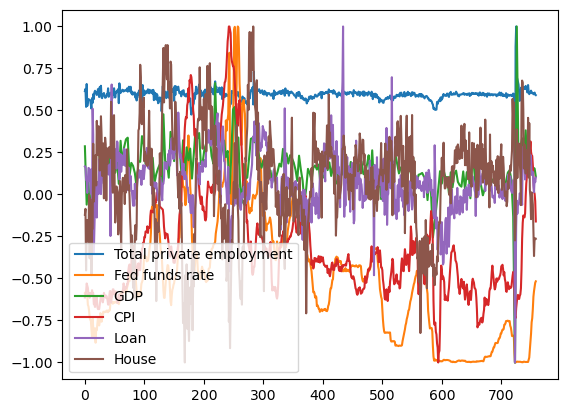

array([False, False, False, False, False, False])

In [6]:
X0 = scale_df(shifted_df0, scaler)
X1 = scale_df(shifted_df1, scaler)
X2= scale_df(shifted_df2, scaler)
X3 = scale_df(shifted_df3, scaler)
X4 = scale_df(shifted_df4, scaler)
X5 = scale_df(shifted_df5, scaler)

temp_list = [X0, X1, X2, X3, X4, X5]
# temp_list = [X1, X2, X3, X4, X5]
# print(X0)
# print(type(X0.shape[0]))
X = np.zeros([X0.shape[0], X0.shape[1], 6])
# X = np.zeros([X0.shape[0], X0.shape[1], 5])
# X.shape
for i in range(len(temp_list)):
    X[:,:,i] = temp_list[i]
    
print(f"X shape is {X.shape}")
# plt.plot(X[:,:,0])
plt.plot(X0[:,0], label = 'Total private employment')
# plt.plot(X0[:,0], label = 'Unemployment rate')
plt.plot(X1[:,0], label = 'Fed funds rate')
plt.plot(X2[:,0], label = 'GDP')
plt.plot(X3[:,0], label = 'CPI')
plt.plot(X4[:,0], label = 'Loan')
plt.plot(X5[:,0], label = 'House')

plt.legend()
plt.show()

np.isnan(X).any(0).any(0)

In [7]:
y_df = pd.read_csv('../Data/Employment_pch_1960.csv')
# y_df = pd.read_csv('../Data/Output_employpch_unemployrate_1960.csv')

y_df = y_df[['Month', 'Total_private_pch']]
y_df = y_df.iloc[lookback:-1,:]
y_df.set_index('Month', inplace = True)
# print(y_df)
assert(y_df.shape[0] == X.shape[0])
                                 
# shifted_df1
y = y_df.to_numpy()

# y_dir = np.sign(y)
# y_dir = y_dir[:,0]
# y_dir
X.shape, y.shape

((759, 6, 6), (759, 1))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False, random_state=8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# print(y_train)

((531, 6, 6), (228, 6, 6), (531, 1), (228, 1))

In [9]:
#add another dimension in the end for Pytorch LSTM
# num_classes = 2
# X_train = X_train.reshape((-1, lookback, 1))
# X_test = X_test.reshape((-1, lookback, 1))

# y_train = y_train.reshape((-1, 1))
# y_test = y_test.reshape((-1, 1))



# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [10]:
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([531, 6, 6]),
 torch.Size([228, 6, 6]),
 torch.Size([531, 1]),
 torch.Size([228, 1]))

In [11]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataset

In [12]:
#wrap dataset in data loaders to get the batches
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(len(train_loader))
# print(len(test_loader))

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.dtype, y_batch.dtype)
    print(x_batch.shape, y_batch.shape)
    break

torch.float32 torch.float32
torch.Size([16, 6, 6]) torch.Size([16, 1])


In [13]:
# rnn for classification

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='tanh', batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out
    

In [14]:
def train_one_epoch(dataloader, model, loss_function, optimizer):
    model.train()
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
#         assert(len(output) == len(y_batch))
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

#         if batch_index % 20 == 19:  # print every 20 batches
#             print(f"Batch {batch_index}")
#             (below 2 calculations should be the same)
#             print(torch.sum(torch.square(output-y_batch)) / batch_size)
#             print(loss.item())
 

In [15]:
def validate_one_epoch(dataloader, model, loss_function):
    model.eval() #evaluation mode
    running_loss = 0.0
    
    for batch_index, batch in enumerate(dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): #not calculating gradients because we're not updating model
            output = model(x_batch)
#             assert(len(output) == len(y_batch))
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    

In [16]:
def mse_calc(y_predict, y_actual):
    assert(len(y_predict) == len(y_actual))
    mse = torch.sum(torch.square(y_actual-y_predict)) / len(y_predict)
    return mse

In [17]:
input_size = 6
hidden_size = 128
num_layers = 6
# num_classes = 2

model = RNN(input_size, hidden_size, num_layers).to(device)
model

RNN(
  (rnn): RNN(6, 128, num_layers=6, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
learning_rate = 0.005
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

all_train_error = []
all_test_error = []

num_epochs = 1000
best_error = 99
best_model_state = {}
for epoch in range(num_epochs):
    
    train_one_epoch(train_loader,model,loss_function,optimizer)
    validate_one_epoch(test_loader, model, loss_function)

    with torch.no_grad():
        # predicted_train = model(X_train.to(device)).to('cpu')
        predicted_train = model(X_train)
        train_error = mse_calc(predicted_train, y_train)
        all_train_error.append(train_error)

    with torch.no_grad():
        # predicted_test = model(X_test.to(device)).to('cpu')
        predicted_test = model(X_test)
        test_error = mse_calc(predicted_test, y_test)
        all_test_error.append(test_error)

    if epoch % 50 == 49:
        print(f'Epoch: {epoch + 1}')
        print(f"training data error is {train_error}")
        print(f"test data error is {test_error}")
#         print(len(predicted_train))
#         print(len(predicted_test))
    if test_error < best_error:
        best_model_state = deepcopy(model.state_dict())
        best_error = test_error


Epoch: 50
training data error is 0.052546896040439606
test data error is 1.2207568883895874
Epoch: 100
training data error is 0.04551084339618683
test data error is 1.2083275318145752
Epoch: 150
training data error is 0.042244404554367065
test data error is 1.2086048126220703
Epoch: 200
training data error is 0.04402434080839157
test data error is 1.2112852334976196
Epoch: 250
training data error is 0.03958858177065849
test data error is 1.2077233791351318
Epoch: 300
training data error is 0.04191402718424797
test data error is 1.2078629732131958
Epoch: 350
training data error is 0.04700082913041115
test data error is 1.208595633506775
Epoch: 400
training data error is 0.03783627226948738
test data error is 1.1973087787628174
Epoch: 450
training data error is 0.03635454922914505
test data error is 1.1907254457473755
Epoch: 500
training data error is 0.037561871111392975
test data error is 1.1880420446395874
Epoch: 550
training data error is 0.036170218139886856
test data error is 1.179

In [19]:
best_model = RNN(input_size, hidden_size, num_layers).to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

RNN(
  (rnn): RNN(6, 128, num_layers=6, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [20]:
with torch.no_grad():
    predicted_train = best_model(X_train.to(device)).to('cpu')
train_error = mse_calc(predicted_train, y_train)
print(f"training data error is {train_error}")

with torch.no_grad():
    predicted_test = best_model(X_test.to(device)).to('cpu')
test_error = mse_calc(predicted_test, y_test)
print(f"test data error is {test_error}")

training data error is 0.031162764877080917
test data error is 1.1430392265319824


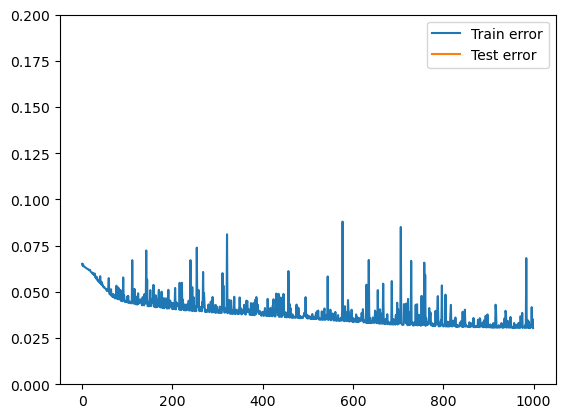

In [21]:
plt.plot(all_train_error, label = 'Train error')
plt.plot(all_test_error, label = 'Test error')
plt.ylim(0,0.2)
plt.legend()
plt.show()

In [22]:
# len(y_test)
# len(predicted_test)

<function matplotlib.pyplot.show(close=None, block=None)>

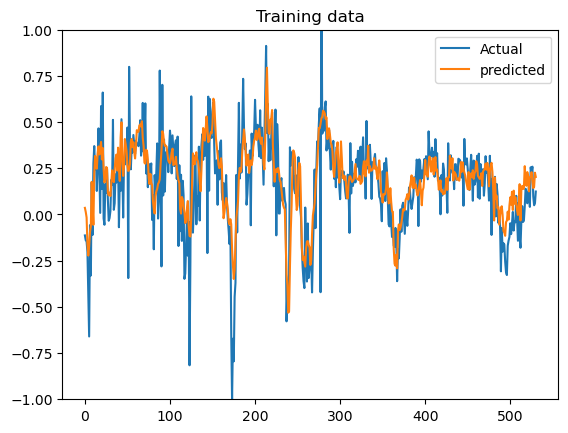

In [23]:
plt.plot(y_train, label = 'Actual')
plt.plot(predicted_train, label = 'predicted')
# plt.xlim(400, 550)
plt.ylim(-1, 1)
plt.title('Training data')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

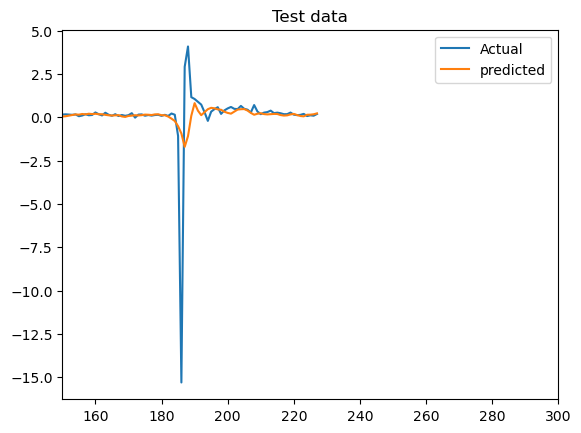

In [43]:
plt.plot(y_test, label = 'Actual')
plt.plot(predicted_test, label = 'predicted')
plt.title('Test data')
plt.xlim(150, 300)
# plt.ylim(-1, 1)
plt.legend()
plt.show

In [25]:
def classify_error(y_predict, y_actual):
    assert(len(y_predict) == len(y_actual))
    actual_sign = torch.sign(y_actual)
    predict_sign = torch.sign(y_predict)
    error = torch.sum(torch.abs(actual_sign - predict_sign) )/2 / len(y_actual)
    
    
    return error

In [26]:
# actual_np = y_test.numpy()
# predict_np = predicted_test.numpy()
# index1 = np.nonzero(actual_np <0)
# print(index1)
# print(len(index1[0]))
# index2 = np.nonzero(predict_np <0)
# print(index2)
# print(len(index2[0]))
# inboth = np.intersect1d(index1[0], index2[0])
# print(len(inboth))
# # type(actual_sign)
# # print(actual_sign)
# # actual_sign[actual_sign >= 0] = 0
# # predict_sign[predict_sign >=0] = 0
# # print(actual_sign)
# # error = torch.sum(torch.abs(actual_sign - predict_sign)) / len(predict_sign)
# # error
# # plt.plot(error)


In [27]:
# def classify_error(y_predict, y_actual):
#     assert(len(y_predict) == len(y_actual))
#     error_array = torch.abs(y_actual - y_predict) / y_actual
    
# #     print(torch.abs(y_actual - y_predict) / y_actual)
#     return error_array

In [28]:
train_error = classify_error(predicted_train, y_train)
test_error = classify_error(predicted_test, y_test)
print(f"training data classification error is {train_error}")
print(f"test data classification error is {test_error}")
# plt.plot(train_error)
# plt.ylim(-1, 1)
# sum(train_error) / len(train_error)

training data classification error is 0.13935969769954681
test data classification error is 0.0833333358168602


In [44]:
y_test.shape

torch.Size([228, 1])

In [45]:
from sklearn.metrics import r2_score
res = r2_score(y_test[:180, 0], predicted_test[:180, 0])
res

0.6141693336208645

In [29]:
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [30]:
# Checking percentage of negative employment change
# temp = y_test[y_test < 0]
# len(temp)
# len(y_test)
# len(temp) / len(y_test)


0.13596491228070176

In [31]:
#save model
# torch.save(best_model_state, './sw_rnn_classify_construction_savedmodel.pt')


# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('model_scripted.pt') # Save

In [32]:
#load model
# model2 = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
# model2.load_state_dict(torch.load('./sw_rnn_classify_construction_savedmodel.pt'))
# model2.eval()

In [33]:
# predicted_test2 = model2(X_test)
# test_error2 = error_rate(predicted_test2, y_test)
# print(f"Saved model produces test data error =  {test_error2}")